# Molecular Dynamics: Lab 1

In part based on [Fortran code from Furio Ercolessi](http://www.fisica.uniud.it/~ercolessi/md/f90/).

In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

## Basics of Molecular Dynamics

In [2]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12,6)

The basic idea of molecular dynamics is to follow the location of the particles in time using Newton's laws. Each particle has a location $\vec{X}_i$ which obeys

$$
\begin{equation}
  m_i \frac{d^2}{d t^2} \vec{X}_i = m_i \vec{A}_i = -\nabla V \left( \vec{X}_1, \dots, \vec{X}_N \right).
\end{equation}
$$

Most of the time we will work in computational coordinates, rescaled by a reference length $L$, so that the particles obey

$$
\begin{equation}
  \frac{d^2}{d t^2} \vec{x}_i = \vec{a}_i = -\nabla V \left( \vec{x}_1, \dots, \vec{x}_N \right).
\end{equation}
$$

This gives us a computational domain, once translated to the centre-of-mass, of $\vec{x} \in [-0.5, 0.5]^3$.

The simplest possibility is that the interaction potential $V$ is the sum of pairwise interactions, 

$$
\begin{equation}
  V \left( \vec{x}_1, \dots, \vec{x}_N \right) = \sum_i \sum_{j>i} \phi \left( L \left| \vec{x}_i - \vec{x}_j \right| \right).
\end{equation}
$$

The most commonly used pairwise interaction potential is the *Lennard-Jones* potential

$$
\begin{equation}
  \phi(r) = 4 \varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right].
\end{equation}
$$

To stop this potential extending for infinite distance a cutoff is used; $\phi(r) \to \phi(r) - \phi(R_c)$, where $R_c$ is a constant (here $2.5$ when $\sigma = 1 = \varepsilon = M_i$).

As, in this case,

$$
\begin{equation}
  \frac{d}{dr} \phi(r) = 24 \left[ 2 \left( \frac{1}{r} \right)^{14} - \left( \frac{1}{r} \right)^{8} \right],
\end{equation}
$$

we have

$$
\begin{equation}
  \vec{a}_i = -\left. \nabla V \right|_{i} = \sum_{j>i}  (\vec{x}_i - \vec{x}_j) \, \frac{d}{dr} \phi(r) - \sum_{j<i}  (\vec{x}_j - \vec{x}_i) \, \frac{d}{dr} \phi(r).
\end{equation}
$$

Note that Newton's third law means that the force on particle $i$ from particle $j$ must be exactly opposite to the force on particle $j$ from particle $i$. So the algorithm can be implemented by setting $\vec{a}_i = 0$ and, for each particle $i$, and for all $j > i$, setting *both*

1. $\vec{a}_i = \vec{a}_i + (\vec{x}_i - \vec{x}_j) \, \frac{d}{dr} \phi(r)$,
2. $\vec{a}_j = \vec{a}_j - (\vec{x}_i - \vec{x}_j) \, \frac{d}{dr} \phi(r)$.

Implement an algorithm to calculate the acceleration given the positions.

In [3]:
def potential(x, BoxSize):
    """
    Compute the accelerations given the locations for the Lennard-Jones potential.
    
    Parameters
    ----------
    
    x : array of float
        Particle positions
        
    Returns
    -------
    
    a : array of float
        Particle accelerations
    """
    
    ndim, N = x.shape
    
    Rc = 2.5
    phic = 4.0 * (Rc**(-12) - Rc**(-6))
    
    a = numpy.zeros_like(x)
    
    for i in range(N):
        for j in range(i+1, N):
            separation = x[:, i] - x[:, j]
            # Fix for periodic boundaries; if any component is > 0.5, there's a periodic point closer.
            for n in range(3):
                if (numpy.abs(separation[n]) > 0.5):
                    separation[n] -= numpy.sign(separation[n])
            # Go to "real" coordinates
            r2 = BoxSize**2 * numpy.dot(separation, separation)
            if (r2 < Rc**2): # Only bother adding the term if the particles are close enough to interact
                phi = 4.0 * (r2**(-6) - r2**(-3)) - phic
                dphi = 24.0 * (2.0*r2**(-7) - r2**(-4))
                a[:, i] += dphi * separation 
                a[:, j] -= dphi * separation 
                
    return a

### Time evolution

The problem with time integrating is that most numerical algorithms do not conserve the total energy of the system, which can be be crucial. Certain algorithms, such as the [velocity Verlet](http://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet) algorithm, do conserve total energy.

#### Velocity Verlet

Given initial positions $\vec{x}$ and velocities $\vec{v}$ of each particle, the algorithm can be written as

1. $x^{n+1} = \vec{x}^n + \Delta t \, \vec{v}^n + \tfrac{1}{2} \Delta t^2 \, \vec{a}^n$
2. $\vec{v}^{*} = \vec{v}^n + \tfrac{1}{2} \Delta t \, \vec{a}^n$;
3. Derive $\vec{a}^{n+1}$ from the interaction potential using $\vec{x}^{n+1}$;
4. $\vec{v}^{n+1} = \vec{v}^{*} + \tfrac{1}{2} \Delta t \vec{a}^{n+1}$.

Implement this algorithm.

In [4]:
def verlet(x, v, a, potential, dt, BoxSize):
    """
    Velocity verlet algorithm.
    
    Parameters
    ----------
    
    x : array of float
        Positions of the particles
    v : array of float
        Velocities of the particles
    a : array of float
        Accelerations of the particles
    potential : function
        Compute the acceleration from the potential
    dt : float
        timestep
        
    
    Returns
    -------
    
    xnew : array of float
        Positions of the particles
    vnew : array of float
        Velocities of the particles
    anew : array of float
        Accelerations of the particles
    """
    
    xnew = x + dt*v + 0.5*dt**2*a
    xnew = reset_particles(xnew)
    vstar = v + 0.5*dt*a
    anew = potential(xnew, BoxSize)
    vnew = vstar + 0.5*dt*anew
    
    return xnew, vnew, anew

### Periodic boundaries

If we just evolved the particles, they could fly off to infinity. Instead it is typical to work inside a box with periodic boundaries, so that there is an "infinite lattice" of particles.

Implement a function that resets the position of particles that leave the given domain; the velocities and particles should remain unchanged.

In [5]:
def reset_particles(x):
    """
    Enforce the particles to lie within a box (periodic boundaries).
    
    Parameters
    ----------
    
    x : array of float
        Location of the particles
    domain : array of float
        Upper and lower boundaries of the domain in each direction
        
    Returns
    -------
    
    xnew : array of float
        Updated location of the particles
    """
    
    domain = numpy.array([[-0.5, 0.5],[-0.5, 0.5],[-0.5, 0.5]])
    widths = domain[:,1] - domain[:,0]
    for n, width in enumerate(widths):
        for i in range(x.shape[1]):
            if (x[n,i] < domain[n,0]):
                x[n,i] += width
            elif (x[n,i] > domain[n,1]):
                x[n,i] -= width
    return x

### What to compute

The fundamental quantity is the location of the particles. However, the thing to analyze will be average properties of the particles; their mean temperature, pressure and energies.

Implement a function, given the particle locations $\vec{x}$ to compute the temperature, where

$$
\begin{align}
%  E_{\text{potential},\ i} &= \sum_{j /ne i} \phi \left( L \left| \vec{x}_i - \vec{x}_j \right| \right), \\
  E_{\text{kinetic},\ i} &= \tfrac{1}{2} L^2 \left| \vec{v}_i \right|^2, \\
  T & = \frac{2}{3 N} \sum_{i=1}^N E_{\text{kinetic},\ i}.
\end{align}
$$

In [6]:
def temperature(v, BoxSize):
    """
    Return the temperature of the particles.
    
    Parameters
    ----------
    
    v : array of float
        Particle velocities
    BoxSize : float
        Physical size of box.
    
    Returns
    -------
    
    T : float
        Temperature
    """
    
    E_kinetic = numpy.zeros((v.shape[1],))
    for i in range(len(E_kinetic)):
        E_kinetic[i] = 0.5 * numpy.dot(BoxSize*v[:,i], BoxSize*v[:,i])
    T = 2.0 / (3.0 * v.shape[1]) * numpy.sum(E_kinetic)
    return T

### Run in a box

Fix the domain to be $\vec{x} \in [0, 6.1984]^3$. Fix the timestep to be $0.032$ and take 100 timesteps, given the initial data prescribed in `input.dat` (see `data/MD/input.dat` on github). Remember to rescale the initial coordinates so that

1. The computational domain is $[-0.5, 0.5]^3$;
2. The average particle location is the origin.

That is, given the data $\vec{X}$ from `input.dat` do

1. $\vec{x} = \vec{X} / L$ where $L = 6.1984$;
2. $\vec{x} \to \vec{x} - \text{average}(\vec{x})$.

In [8]:
x = numpy.loadtxt("./input.dat", skiprows=1)
x = x.transpose()

In [9]:
BoxSize = 6.1984

v = numpy.zeros_like(x)
#a = np.zeros_like(x)

# Shift to the computational coordinates.
x = x / BoxSize - 0.5
# Move to centre-of-mass coordinates.
#mass_centre = np.sum(x, axis=1) / float(x.shape[1])
#for i in range(x.shape[1]):
#    x[:,i] -= mass_centre

a = potential(x, BoxSize)

# Now in this domain
domain = numpy.array([[-0.5, 0.5],[-0.5, 0.5],[-0.5, 0.5]])
dt = 0.032
nsteps = 100
t = numpy.zeros((nsteps+1,))
t[0] = 0.0
positions = numpy.zeros((nsteps+1, x.shape[0], x.shape[1]))
positions[0,:,:] = x.copy()
T = numpy.zeros_like(t)
T[0] = temperature(v, BoxSize)

In [10]:
for n in range(nsteps):
    t[n+1] = t[n]+dt
    x = reset_particles(x)
    x, v, a = verlet(x, v, a, potential, dt, BoxSize)
    positions[n+1,:,:] = x.copy()
    T[n+1] = temperature(v, BoxSize)

Then plot some basic quantities, such as

1. The temperature as a function of time;
2. The trajectory of the first two particles as a function of time (using `plot3D`);
3. The trajectories of all the particles.

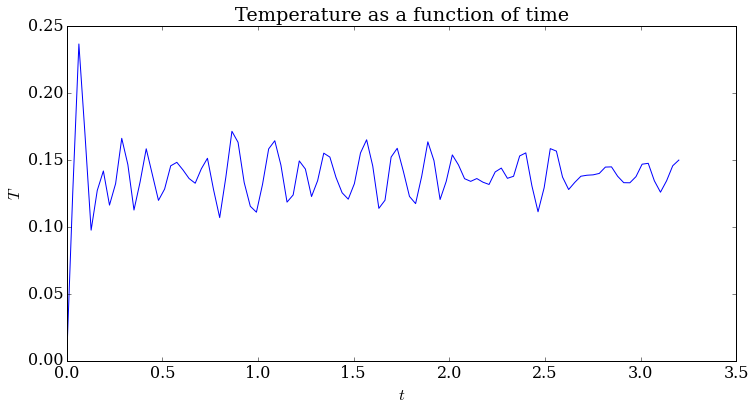

In [11]:
pyplot.plot(t,T)
pyplot.xlabel(r"$t$")
pyplot.ylabel(r"$T$")
pyplot.title("Temperature as a function of time");

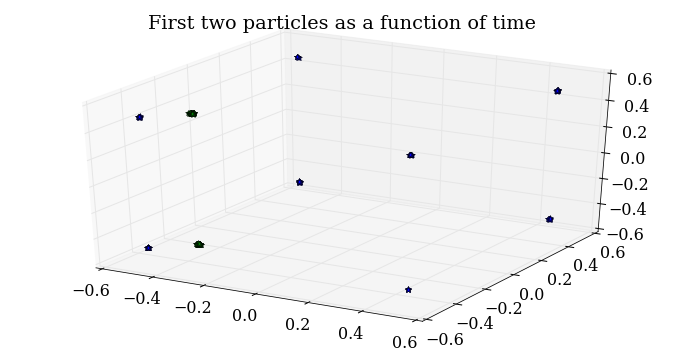

In [12]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
for particle in range(2):
    ax.plot3D(positions[:,0,particle], positions[:,1,particle], positions[:,2,particle], '*');
ax.set_title('First two particles as a function of time');

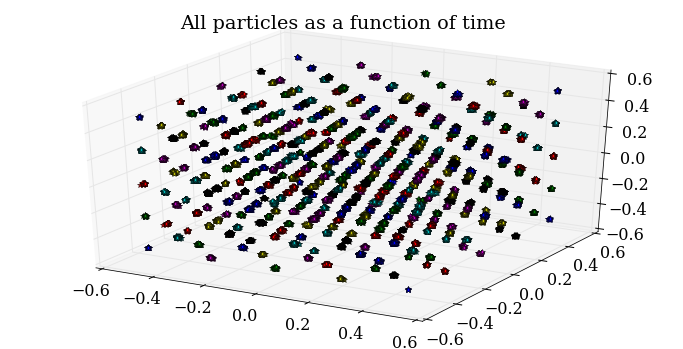

In [13]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
for particle in range((positions.shape)[2]):
    ax.plot3D(positions[:,0,particle], positions[:,1,particle], positions[:,2,particle], '*');
ax.set_title('All particles as a function of time');